# League of Legends World Championship 2025

Step 1: Import all the libraries we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

Step 2: Load Data

In [2]:
df = pd.read_csv('Worlds_MainEvent_2024.csv', sep = ';')

print("Data loaded succesfully")

Data loaded succesfully


Step 3: Read the Data

In [3]:
print("First five rows of Data")
print(df.head())

print("\nDataFrame Information (columns, non-null counts, data types):")
df.info()


First five rows of Data
   Player     Role Team Opponent Team Opponent Player        Date Round  Day  \
0     Bin      TOP  BLG           MDK           Myrwn  03.10.2024     1    1   
1     Wei   JUNGLE  BLG           MDK          Elyoya  03.10.2024     1    1   
2  Knight      MID  BLG           MDK       Fresskowy  03.10.2024     1    1   
3     Elk  ADCARRY  BLG           MDK            Supa  03.10.2024     1    1   
4      ON  SUPPORT  BLG           MDK          Alvaro  03.10.2024     1    1   

    Patch                Stage  ...  Damage self mitigated  \
0  v14.18  Worlds_MainEvent_24  ...                  11181   
1  v14.18  Worlds_MainEvent_24  ...                  28792   
2  v14.18  Worlds_MainEvent_24  ...                   6396   
3  v14.18  Worlds_MainEvent_24  ...                   9455   
4  v14.18  Worlds_MainEvent_24  ...                  12774   

   Total Damage Shielded On Teammates  Time ccing others  Total Time CC Dealt  \
0                                   0    

Step 4: Clean the Data

In [4]:
# Clean column names:
df.columns = df.columns.str.lower().str.replace('[^a-zA-Z0-9@+_%-]', '_', regex=True)
df.columns = df.columns.str.replace('__', '_', regex=True).str.strip('_') # Clean up double underscores or trailing/leading
print("Column names cleaned.")

columns_to_drop_from_df = [
    'opponent_player',
    'cs_in_team_s_jungle',
    'cs_in_enemy_jungle',
    'physical_damage',
    'magic_damage',
    'true_damage',
    'total_heals_on_teammates',
    'damage_self_mitigated',
    'total_damage_shielded_on_teammates',
    'time_ccing_others',
    'consumables_purchased',
    'items_purchased',
    'shutdown_bounty_collected',
    'shutdown_bounty_lost',
    'quadra_kills',
    'penta_kills',
    'ban_opponent',
    'opponent_team', 
    'pick', 
    'pick_opponent', 
    'champion_opponent',
    'patch',
    'stage',
    'solo_kills', 
    'double_kills',
    'triple_kills' 
]

# Drop the columns from the DataFrame 'df'
df.drop(columns=columns_to_drop_from_df, inplace=True, errors='ignore')


Column names cleaned.


Step 5: Transform Data to datetime

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

print("Date column converted to datetime objects.")
print(df[['date']].head())

Date column converted to datetime objects.
        date
0 2024-10-03
1 2024-10-03
2 2024-10-03
3 2024-10-03
4 2024-10-03


Step 6: Transform match time to readable time format in minutes

In [6]:
def time_to_minutes(time_str):
    """Converts a time string (HH:MM:SS or MM:SS) to total minutes."""
    if pd.isna(time_str) or time_str == '0:00:00' or time_str == '0:00': # Added 0:00 check
        return np.nan
    try:
        parts = list(map(int, time_str.split(':')))
        if len(parts) == 3:
            hours, minutes, seconds = parts
        elif len(parts) == 2:
            hours = 0 # Assume 0 hours if only MM:SS
            minutes, seconds = parts
        else:
            return np.nan # Handle unexpected formats

        return hours * 60 + minutes + seconds / 60
    except ValueError: # Catch errors during int conversion (e.g., non-numeric parts)
        return np.nan

df['game_time_in_minutes'] = df['time'].apply(time_to_minutes)

df.drop(columns=['time'], inplace=True, errors='ignore')

print("Game 'time' column converted to 'game_time_in_minutes' (numeric) and original 'time' dropped.")
print(df[['game_time_in_minutes']].head())


Game 'time' column converted to 'game_time_in_minutes' (numeric) and original 'time' dropped.
   game_time_in_minutes
0                  26.6
1                  26.6
2                  26.6
3                  26.6
4                  26.6


Step 7: Transform the outcome from string to binary for easy calculations

In [7]:
df['outcome_numeric'] = df['outcome'].apply(lambda x: 1 if x == 'Win' else 0)

print("Outcome column converted to 'outcome_numeric' (1=Win, 0=Loss).")
print(df[['outcome', 'outcome_numeric']].head())


Outcome column converted to 'outcome_numeric' (1=Win, 0=Loss).
  outcome  outcome_numeric
0     Win                1
1     Win                1
2     Win                1
3     Win                1
4     Win                1


Step 8: We make sure all columns are filled with the same type of data

In the case of KDA, sometimes it appears as "Perfect_KDA" so we must calculate ourselves using "Kills" and "Assists"

In [8]:
numeric_cols = [
    'kills', 'deaths', 'assists',
    'kda',
    'level', 'cs', 'csm', 'golds', 'gpm', 'gold_percentage',
    'vision_score', 'wards_placed', 'wards_destroyed', 'control_wards_purchased', 'detector_wards_placed',
    'vspm', 'wpm', 'vwpm', 'wcpm', 'vs_percentage', 'total_damage_to_champion',
    'dpm', 'dmg_percentage', 'k_a_per_minute', 'kp_percentage',
    'gd@15', 'csd@15', 'xpd@15', 'lvld@15', 'objectives_stolen',
    'damage_dealt_to_turrets', 'damage_dealt_to_buildings', 'total_heal',
    'total_time_cc_dealt',
    'total_damage_taken', 'total_time_spent_dead',
    'turrets_team', 'dragon_team', 'baron_team',
    'game_time_in_minutes', 
    'outcome_numeric'
]

# Filter numeric_cols to only include columns that are actually present in df
# This handles cases where columns might have been dropped or renamed
numeric_cols = [col for col in numeric_cols if col in df.columns]

print("Starting comprehensive numeric type conversion and KDA handling...")

# --- Step 1: 
for col in ['kills', 'deaths', 'assists']:
    if col in df.columns: # Check if column exists
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(0) # Fill NaNs for core KDA calculation

# --- Step 2: Handle 'perfect_kda' string by calculating KDA for those specific rows ---
if 'kda' in df.columns: 
    df['kda'] = df['kda'].astype(str)
    is_perfect_kda = (df['kda'].str.lower() == 'perfect_kda')

    df.loc[is_perfect_kda, 'kda'] = (
        df.loc[is_perfect_kda, 'kills'] + df.loc[is_perfect_kda, 'assists']
    )

# --- Step 3: General numeric conversion for all designated columns ---
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)



Starting comprehensive numeric type conversion and KDA handling...


Step 9: If for some reason the "Ban" data is empty, we have to add the value "No Ban" to keep the column in the object dtype

In [9]:
print("Handling missing values in 'ban' column (forcing string type)...")

cols_to_impute_with_string = ['ban']
placeholder_string = 'No Ban'

for col in cols_to_impute_with_string:
    if col in df.columns: 
        if df[col].isnull().any():
            nan_count = df[col].isnull().sum()
            print(f"  - Found {nan_count} missing value(s) in '{col}'. Current dtype: {df[col].dtype}")
            df[col] = df[col].astype(object) 
            df[col] = df[col].fillna(placeholder_string) 

            print(f"  - Imputed '{col}' with '{placeholder_string}'. New dtype: {df[col].dtype}")
        else:
            print(f"  - No missing values found in '{col}'. Current dtype: {df[col].dtype}")
    else:
        print(f"  - Column '{col}' not found in DataFrame. Skipping imputation.")



Handling missing values in 'ban' column (forcing string type)...
  - Found 1 missing value(s) in 'ban'. Current dtype: object
  - Imputed 'ban' with 'No Ban'. New dtype: object


Step 10: We begin to create "team_df" to have easy access to the data of a single team in a single match

In [10]:
sum_cols = [
    'kills', 'deaths', 'assists', 'cs', 'golds', 'vision_score', 'wards_placed',
    'wards_destroyed', 'control_wards_purchased', 'detector_wards_placed',
    'total_damage_to_champion',
    'damage_dealt_to_turrets', 'damage_dealt_to_buildings', 'total_heal',
    'total_time_cc_dealt', 'total_damage_taken',
    'objectives_stolen'
]

# Define columns that should be averaged for each team (e.g., per-minute or percentage stats)
mean_cols = [
    'level', 'csm', 'gpm', 'gold_percentage', 'vspm', 'wpm', 'vwpm', 'wcpm', 'vs_percentage',
    'dpm', 'dmg_percentage', 'k_a_per_minute', 'kp_percentage', 'gd@15', 'csd@15', 'xpd@15', 'lvld@15',
    'total_time_spent_dead'
]

# Identify columns that are unique per game/team instance and should be taken as first/max/min
first_cols = [
    'round', 'day', 'format', 'no_game',
    'outcome', 'outcome_numeric',
    'turrets_team', 'dragon_team', 'baron_team',
    'game_time_in_minutes',
    'player',
    'ban'
]

# Create a mapping for aggregation functions
aggregation_dict = {col: 'sum' for col in sum_cols}
aggregation_dict.update({col: 'mean' for col in mean_cols})
aggregation_dict.update({col: 'first' for col in first_cols})

# Filter aggregation_dict to only include columns that are actually present in df
final_aggregation_dict = {k: v for k, v in aggregation_dict.items() if k in df.columns}
print(f"Aggregating {len(final_aggregation_dict)} columns...")

# Group by unique game identifier (date and game_of_day), then Side and Team name
team_df = df.groupby(['date', 'game_of_day', 'side', 'team']).agg(final_aggregation_dict).reset_index()

# Explicitly sort the DataFrame to pair opposing teams for each game
team_df = team_df.sort_values(by=['date', 'game_of_day', 'side']).reset_index(drop=True)

# Rename columns to reflect aggregation (e.g., 'kills' becomes 'team_kills')
columns_to_rename_after_agg = [col for col in (sum_cols + mean_cols) if col in team_df.columns]
team_df.rename(columns={col: f'team_{col}' for col in columns_to_rename_after_agg}, inplace=True)


# Post-aggregation, Team KDA needs to be recalculated, as it's a ratio.
if 'team_kda' in team_df.columns:
    print("Recalculating team_kda...")
    team_df['team_kda'] = team_df.apply(
        lambda row: (row['team_kills'] + row['team_assists']) / row['team_deaths'] if row['team_deaths'] != 0 else (row['team_kills'] + row['team_assists']),
        axis=1
    )
    team_df['team_kda'] = team_df['team_kda'].replace([np.inf, -np.inf], np.nan)
else:
    print("Calculating team_kda for the first time...")
    team_df['team_kda'] = team_df.apply(
        lambda row: (row['team_kills'] + row['team_assists']) / row['team_deaths'] if row['team_deaths'] != 0 else (row['team_kills'] + row['team_assists']),
        axis=1
    )
    team_df['team_kda'] = team_df['team_kda'].replace([np.inf, -np.inf], np.nan)


Aggregating 42 columns...
Calculating team_kda for the first time...


Step 11: We change the "team" column to "team_name" for coherency purposes in the future

In [11]:
print("Renaming 'team' column to 'team_name' in team_df...")

if 'team' in team_df.columns:
    team_df.rename(columns={'team': 'team_name'}, inplace=True)
    print("Column 'team' successfully renamed to 'team_name'.")
else:
    print("Column 'team' not found in team_df. Check previous steps.")


Renaming 'team' column to 'team_name' in team_df...
Column 'team' successfully renamed to 'team_name'.


Step 12: We start the process of creating "match_df" to have all the data of a single match in one row

In [12]:
print("Pairing opposing teams to create match-level data...")

# Separate blue and red sides
blue_side_df = team_df[team_df['side'] == 'Blue'].copy()
red_side_df = team_df[team_df['side'] == 'Red'].copy()

# Rename columns to distinguish between blue and red team stats
blue_side_df.columns = [f'blue_{col}' if col not in ['date', 'game_of_day'] else col for col in blue_side_df.columns]
red_side_df.columns = [f'red_{col}' if col not in ['date', 'game_of_day'] else col for col in red_side_df.columns]

# Merge the two DataFrames on 'date' and 'game_of_day' to create match-level rows
match_df = pd.merge(
    blue_side_df,
    red_side_df,
    on=['date', 'game_of_day'],
    how='inner',
    suffixes=('_blue', '_red')
)

if 'red_outcome' in match_df.columns: 
    match_df.drop(columns=['red_outcome'], inplace=True, errors='ignore')
if 'red_outcome_numeric' in match_df.columns:
    match_df.drop(columns=['red_outcome_numeric'], inplace=True, errors='ignore')
match_df.rename(columns={'blue_outcome': 'outcome', 'blue_outcome_numeric': 'outcome_numeric'}, inplace=True)



columns_to_drop_from_red = [
    'red_round', 'red_day', 'red_format', 'red_no_game', 'red_turrets_team',
    'red_dragon_team', 'red_baron_team', 'red_game_time_in_minutes',
    'red_player',
    'red_ban' 
]

match_df.drop(columns=columns_to_drop_from_red, inplace=True, errors='ignore')



Pairing opposing teams to create match-level data...


Step 13: We calculate the difference in statistics of the teams and separete the data per side

In [13]:
print("Creating comparison features (differences and ratios) between Blue and Red teams...")

base_stats_cols = [
    'kills', 'deaths', 'assists', 'cs', 'golds', 'vision_score', 'wards_placed',
    'wards_destroyed', 'control_wards_purchased', 'detector_wards_placed',
    'total_damage_to_champion', 'damage_dealt_to_turrets', 'damage_dealt_to_buildings',
    'total_heal', 'total_time_cc_dealt', 'total_damage_taken',
    'objectives_stolen',
    'level', 'csm', 'gpm', 'gold_percentage', 'vspm', 'wpm', 'vwpm', 'wcpm',
    'vs_percentage', 'dpm', 'dmg_percentage', 'k_a_per_minute', 'kp_percentage',
    'gd@15', 'csd@15', 'xpd@15', 'lvld@15', 'total_time_spent_dead', 'kda'
]

base_stats_cols = [f'team_{col}' for col in base_stats_cols]

for col in base_stats_cols:
    blue_col = f'blue_{col}'
    red_col = f'red_{col}'

    if blue_col in match_df.columns and red_col in match_df.columns:
        match_df[f'diff_{col}'] = match_df[blue_col] - match_df[red_col]

        epsilon = 1e-6
        match_df[f'ratio_{col}'] = match_df[blue_col] / (match_df[red_col] + epsilon)

print("\nFirst 5 rows of match_df with new comparison features (showing some examples):")
sample_cols = [
    'outcome_numeric',
    'blue_team_kills', 'red_team_kills', 'diff_team_kills', 'ratio_team_kills',
    'blue_team_golds', 'red_team_golds', 'diff_team_golds', 'ratio_team_golds',
    'blue_team_cs', 'red_team_cs', 'diff_team_cs', 'ratio_team_cs'
]
sample_cols_existing = [col for col in sample_cols if col in match_df.columns]
print(match_df[sample_cols_existing].head())


Creating comparison features (differences and ratios) between Blue and Red teams...

First 5 rows of match_df with new comparison features (showing some examples):
   outcome_numeric  blue_team_kills  red_team_kills  diff_team_kills  \
0                1               21              10               11   
1                1               14               9                5   
2                1               19              10                9   
3                0               11              18               -7   
4                0                9              20              -11   

   ratio_team_kills  blue_team_golds  red_team_golds  diff_team_golds  \
0          2.100000            56402           42169            14233   
1          1.555555            54986           51254             3732   
2          1.900000            84573           77146             7427   
3          0.611111            64682           66266            -1584   
4          0.450000            59311  

Step 14: Select features and targets of the model

In [14]:
print("Selecting features (X) and target (y), and dropping redundant columns from match_df...")

# Define the target variable
y = match_df['outcome_numeric']

# Columns to explicitly exclude from features X from the start
initial_cols_to_exclude = [
    'outcome_numeric',     
    'outcome',             
    'date',                
    'game_of_day',         
    'blue_side',           
    'red_side',            
    'blue_player',         
    'red_player',          
]

# Create the initial feature DataFrame X by dropping the excluded columns
X = match_df.drop(columns=initial_cols_to_exclude, errors='ignore').copy()

# Now, identify and drop the raw 'blue_team_{stat}' and 'red_team_{stat}' columns.

cols_to_drop_raw_stats_pattern = [
    col for col in X.columns
    if (col.startswith('blue_team_') or col.startswith('red_team_')) and
       not col.endswith('_team') and
       not col.endswith('_ban')      
]

X.drop(columns=cols_to_drop_raw_stats_pattern, inplace=True, errors='ignore')


print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

print("\nFirst 5 rows of Features (X):")
print(X.head())

print("\nData types of Features (X):")
X.info(verbose=True, show_counts=True)

print("\nNaN values in Features (X) after selection:")
print(X.isnull().sum()[X.isnull().sum() > 0])

Selecting features (X) and target (y), and dropping redundant columns from match_df...
Features (X) shape: (82, 71)
Target (y) shape: (82,)

First 5 rows of Features (X):
  blue_round  blue_day  blue_format  blue_no_game  blue_turrets_team  \
0          1         1            1             1                 11   
1          1         1            1             1                  6   
2          1         1            1             1                  9   
3          1         1            1             1                  4   
4          1         1            1             1                  6   

   blue_dragon_team  blue_baron_team  blue_game_time_in_minutes blue_ban  \
0                 4                1                  26.600000  Nidalee   
1                 3                0                  30.566667  Sejuani   
2                 5                1                  45.216667  Orianna   
3                 2                2                  35.600000       Vi   
4               

15: Perform One-Hot Encoding to transfro the strings into numbers

In [15]:
print("One-hot encoding categorical features in X...")

# Identify categorical columns (those with 'object' dtype)
categorical_cols = X.select_dtypes(include='object').columns
print(f"Categorical columns to encode: {list(categorical_cols)}")

if len(categorical_cols) > 0:
    # Apply one-hot encoding
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=False) # drop_first=False keeps all categories
    print("One-hot encoding complete.")
else:
    print("No object dtype columns found for one-hot encoding. Skipping.")


print(f"\nFeatures (X) shape after one-hot encoding: {X.shape}")
print("\nFirst 5 rows of Features (X) after encoding (showing new columns):")
print(X.head())

print("\nData types of Features (X) after one-hot encoding:")
# Using verbose=True to show all columns and their dtypes after encoding
X.info(verbose=True, show_counts=True)

print("\nNaN values in Features (X) after one-hot encoding:")
print(X.isnull().sum()[X.isnull().sum() > 0])

One-hot encoding categorical features in X...
Categorical columns to encode: ['blue_round', 'blue_ban']
One-hot encoding complete.

Features (X) shape after one-hot encoding: (82, 103)

First 5 rows of Features (X) after encoding (showing new columns):
   blue_day  blue_format  blue_no_game  blue_turrets_team  blue_dragon_team  \
0         1            1             1                 11                 4   
1         1            1             1                  6                 3   
2         1            1             1                  9                 5   
3         1            1             1                  4                 2   
4         1            1             1                  6                 2   

   blue_baron_team  blue_game_time_in_minutes  diff_team_kills  \
0                1                  26.600000               11   
1                0                  30.566667                5   
2                1                  45.216667                9   
3       

Step 16: Perform the Train-Test Split

In [16]:
print("Splitting data into training and testing sets...")

test_size = 0.2

# Define a random state for reproducibility
random_state = 42

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

print("\nData splitting complete.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Optional: Check the distribution of the target variable in train and test sets
print("\nTarget distribution in y_train:")
print(y_train.value_counts(normalize=True))
print("\nTarget distribution in y_test:")
print(y_test.value_counts(normalize=True))

Splitting data into training and testing sets...

Data splitting complete.
X_train shape: (65, 103)
X_test shape: (17, 103)
y_train shape: (65,)
y_test shape: (17,)

Target distribution in y_train:
outcome_numeric
1    0.569231
0    0.430769
Name: proportion, dtype: float64

Target distribution in y_test:
outcome_numeric
1    0.588235
0    0.411765
Name: proportion, dtype: float64


Step 17: Model Init and training

In [17]:
print("Building and training a Logistic Regression model...")

# 1. Define the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, solver='liblinear')

# 2. Train the model
print("\nTraining the Logistic Regression model...")
log_reg_model.fit(X_train, y_train)
print("Logistic Regression model training complete.")

# 3. Make predictions on the test set
y_pred_proba_lr = log_reg_model.predict_proba(X_test)[:, 1]
y_pred_lr = (y_pred_proba_lr > 0.5).astype(int)

# 4. Evaluate the model
print("\nEvaluating the Logistic Regression model on the test set...")

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"Logistic Regression Test Accuracy: {accuracy_lr:.4f}")
print(f"Logistic Regression Test Precision: {precision_lr:.4f}")
print(f"Logistic Regression Test Recall: {recall_lr:.4f}")
print(f"Logistic Regression Test F1-Score: {f1_lr:.4f}")
print(f"Logistic Regression Test ROC AUC: {roc_auc_lr:.4f}")

print("\nLogistic Regression model setup, training, and evaluation completed.")

Building and training a Logistic Regression model...

Training the Logistic Regression model...
Logistic Regression model training complete.

Evaluating the Logistic Regression model on the test set...
Logistic Regression Test Accuracy: 1.0000
Logistic Regression Test Precision: 1.0000
Logistic Regression Test Recall: 1.0000
Logistic Regression Test F1-Score: 1.0000
Logistic Regression Test ROC AUC: 1.0000

Logistic Regression model setup, training, and evaluation completed.


Step 18: Analyze aspects that are influetial in a win

Inspecting Logistic Regression coefficients...

Top 15 Most Influential Features (by absolute coefficient value):
                                Feature  Coefficient  Abs_Coefficient
15                      diff_team_golds     0.000598         0.000598
29    diff_team_damage_dealt_to_turrets     0.000469         0.000469
31  diff_team_damage_dealt_to_buildings     0.000469         0.000469
27   diff_team_total_damage_to_champion     0.000391         0.000391
33                 diff_team_total_heal     0.000332         0.000332
61                     diff_team_xpd@15     0.000040         0.000040
37         diff_team_total_damage_taken    -0.000037         0.000037
35        diff_team_total_time_cc_dealt     0.000025         0.000025
57                      diff_team_gd@15     0.000017         0.000017
40         ratio_team_objectives_stolen     0.000008         0.000008
6             blue_game_time_in_minutes     0.000004         0.000004
45                        diff_team_gpm     0.

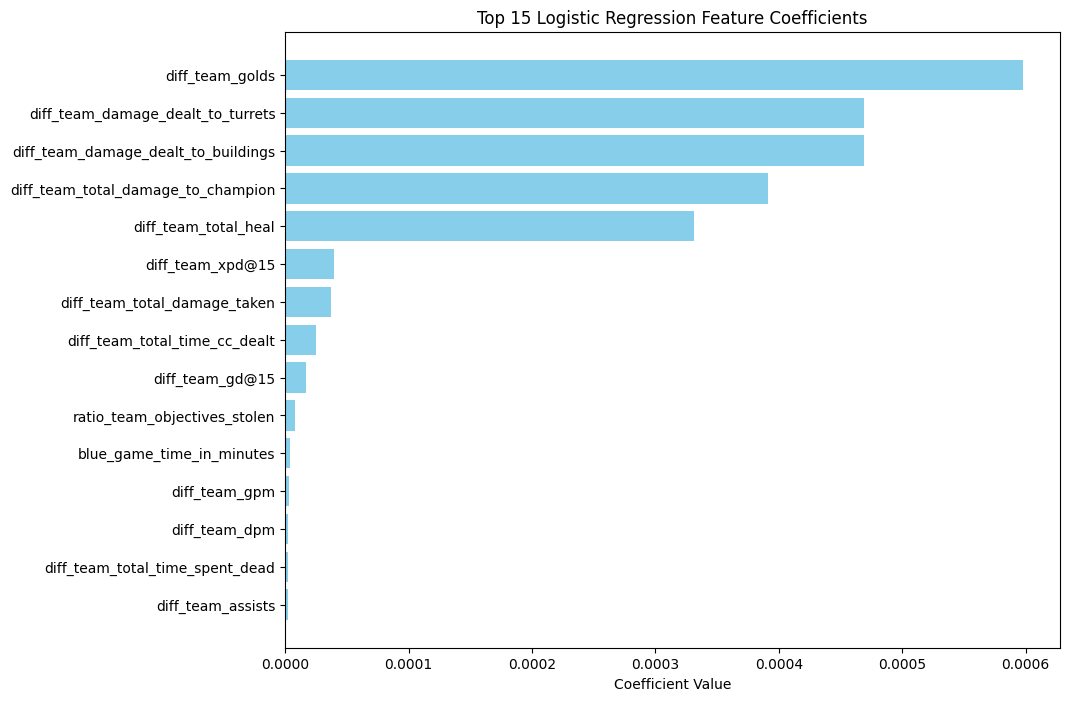


Logistic Regression coefficient inspection complete.


In [18]:
print("Inspecting Logistic Regression coefficients...")

# Get feature names from X_train
feature_names = X_train.columns

# Get coefficients from the trained model
coefficients = log_reg_model.coef_[0]

# Create a DataFrame to easily view coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort by absolute coefficient value to see the most influential features
coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nTop 15 Most Influential Features (by absolute coefficient value):")
print(coef_df.head(15))

print("\nFeatures with the largest positive influence on winning:")
print(coef_df[coef_df['Coefficient'] > 0].head(10))

print("\nFeatures with the largest negative influence on winning:")
print(coef_df[coef_df['Coefficient'] < 0].head(10))

# Optional: Plotting coefficients for better visualization (can be many features)
# You might need to adjust figsize or max_features if there are too many to plot meaningfully
plt.figure(figsize=(10, 8))
plt.barh(coef_df['Feature'].head(15), coef_df['Abs_Coefficient'].head(15), color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Top 15 Logistic Regression Feature Coefficients')
plt.gca().invert_yaxis() # Put largest coefficient at the top
plt.show()

print("\nLogistic Regression coefficient inspection complete.")

Step 19: We analyze the winrate and average kills per game of the teams

Analyzing individual team performance during the championship...

--- Team Win Rates ---
team_name
T1     0.764706
BLG    0.650000
LNG    0.625000
GEN    0.571429
TL     0.500000
TES    0.500000
HLE    0.500000
FLY    0.500000
WBG    0.500000
GAM    0.375000
G2     0.375000
FNC    0.333333
DK     0.333333
MDK    0.200000
PSG    0.200000
PNG    0.000000
Name: outcome_numeric, dtype: float64


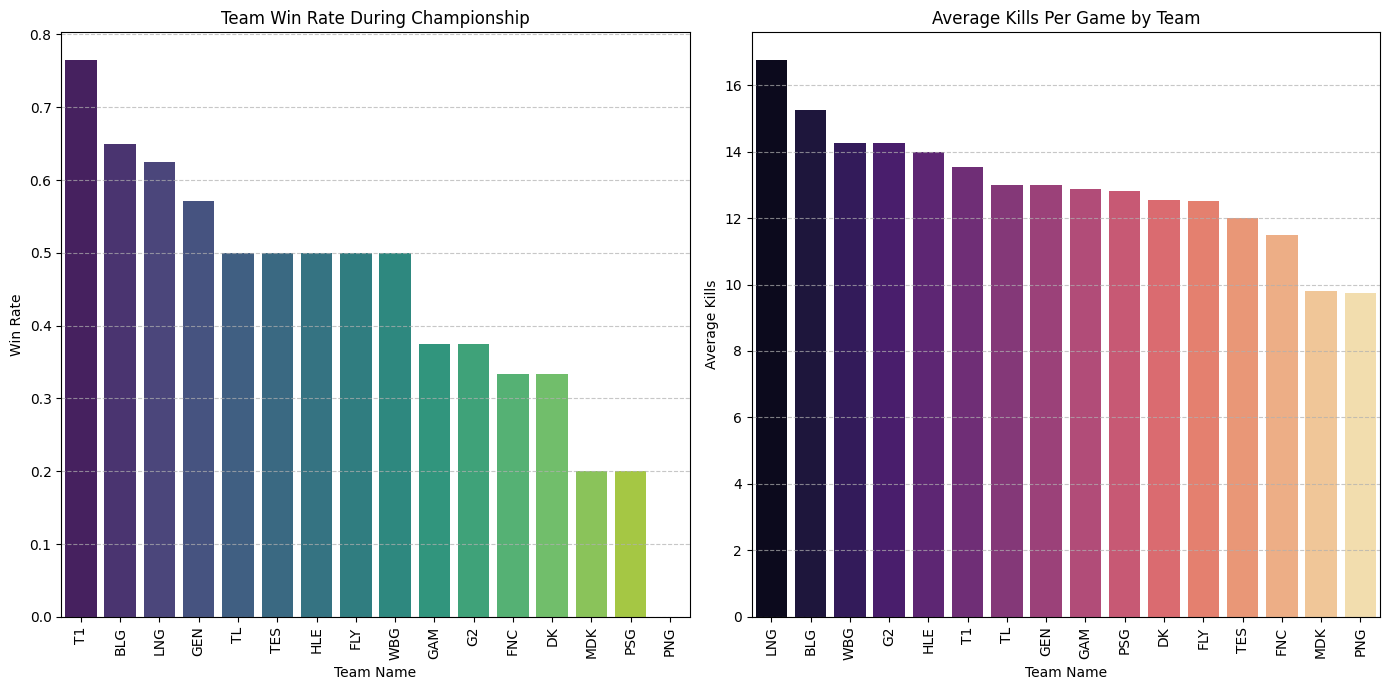


--- Performance by Round (e.g., Win Rate per Round) ---


<Figure size 1200x600 with 0 Axes>

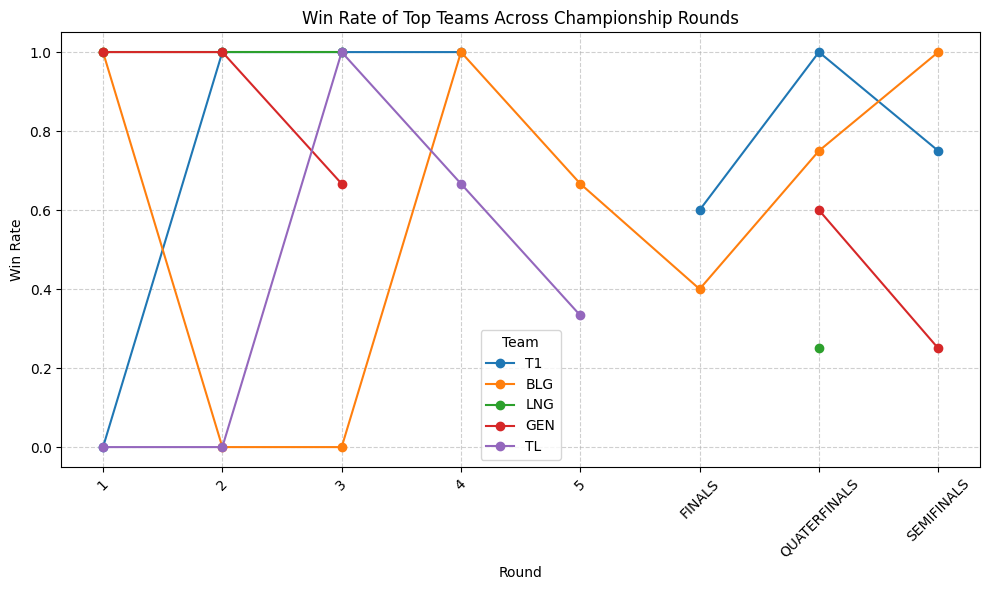


Team performance analysis complete.


In [19]:
print("Analyzing individual team performance during the championship...")


# 1. Calculate Win Rate per Team
team_win_rate = team_df.groupby('team_name')['outcome_numeric'].mean().sort_values(ascending=False)
print("\n--- Team Win Rates ---")
print(team_win_rate)

# 2. Calculate Average Performance Metrics per Team
performance_metrics = [
    'team_kills', 'team_deaths', 'team_assists',
    'team_golds', 'team_total_damage_to_champion', 'turrets_team',
    'dragon_team', 'baron_team', 'team_wards_placed',
    'team_cs', 'team_kda'
]

# Calculate the average of these metrics for each team
team_avg_stats = team_df.groupby('team_name')[performance_metrics].mean()

# 3. Combine Win Rate with Average Stats (Optional, for comprehensive view)
team_overall_performance = pd.merge(team_win_rate.rename('Win_Rate'), team_avg_stats,
                                    left_index=True, right_index=True)

plt.figure(figsize=(14, 7))

# Plot 1: Win Rate of all teams
plt.subplot(1, 2, 1)
sns.barplot(x=team_win_rate.index, y=team_win_rate.values, hue=team_win_rate.index, legend=False, palette='viridis')
plt.xticks(rotation=90)
plt.title('Team Win Rate During Championship')
plt.xlabel('Team Name')
plt.ylabel('Win Rate')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Average Kills per Team
avg_kills = team_avg_stats['team_kills'].sort_values(ascending=False)
plt.subplot(1, 2, 2) 
sns.barplot(x=avg_kills.index, y=avg_kills.values, hue=team_win_rate.index, legend=False, palette='magma')
plt.xticks(rotation=90)
plt.title('Average Kills Per Game by Team')
plt.xlabel('Team Name')
plt.ylabel('Average Kills')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 5. Advanced Analysis: Performance Over Rounds
if 'round' in team_df.columns:
    print("\n--- Performance by Round (e.g., Win Rate per Round) ---")
    team_win_rate_by_round = team_df.groupby(['team_name', 'round'])['outcome_numeric'].mean().unstack()

    # Example: Plotting a few top teams' win rates across rounds
    if not team_win_rate_by_round.empty:
        plt.figure(figsize=(12, 6))
        top_teams_for_plot = team_win_rate.head(5).index
        team_win_rate_by_round.loc[top_teams_for_plot].T.plot(kind='line', marker='o', figsize=(10, 6))
        plt.title('Win Rate of Top Teams Across Championship Rounds')
        plt.xlabel('Round')
        plt.ylabel('Win Rate')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(rotation=45)
        plt.legend(title='Team')
        plt.tight_layout()
        plt.show()


print("\nTeam performance analysis complete.")

Step 20: We check which champions are the most pickes/banned

Analyzing top 10 most played and most banned characters...

--- Top 10 Most Played Characters ---
champion
Rell       44
Jax        37
Skarner    33
Gnar       32
Kaisa      30
Yone       29
Rumble     26
Ahri       26
Sejuani    25
Vi         25
Name: count, dtype: int64

--- Top 10 Most Banned Characters ---
ban
Aurora     65
Yone       49
Ashe       45
Kalista    42
Skarner    39
Ziggs      37
Jax        31
Poppy      27
Kaisa      27
Orianna    24
Name: count, dtype: int64


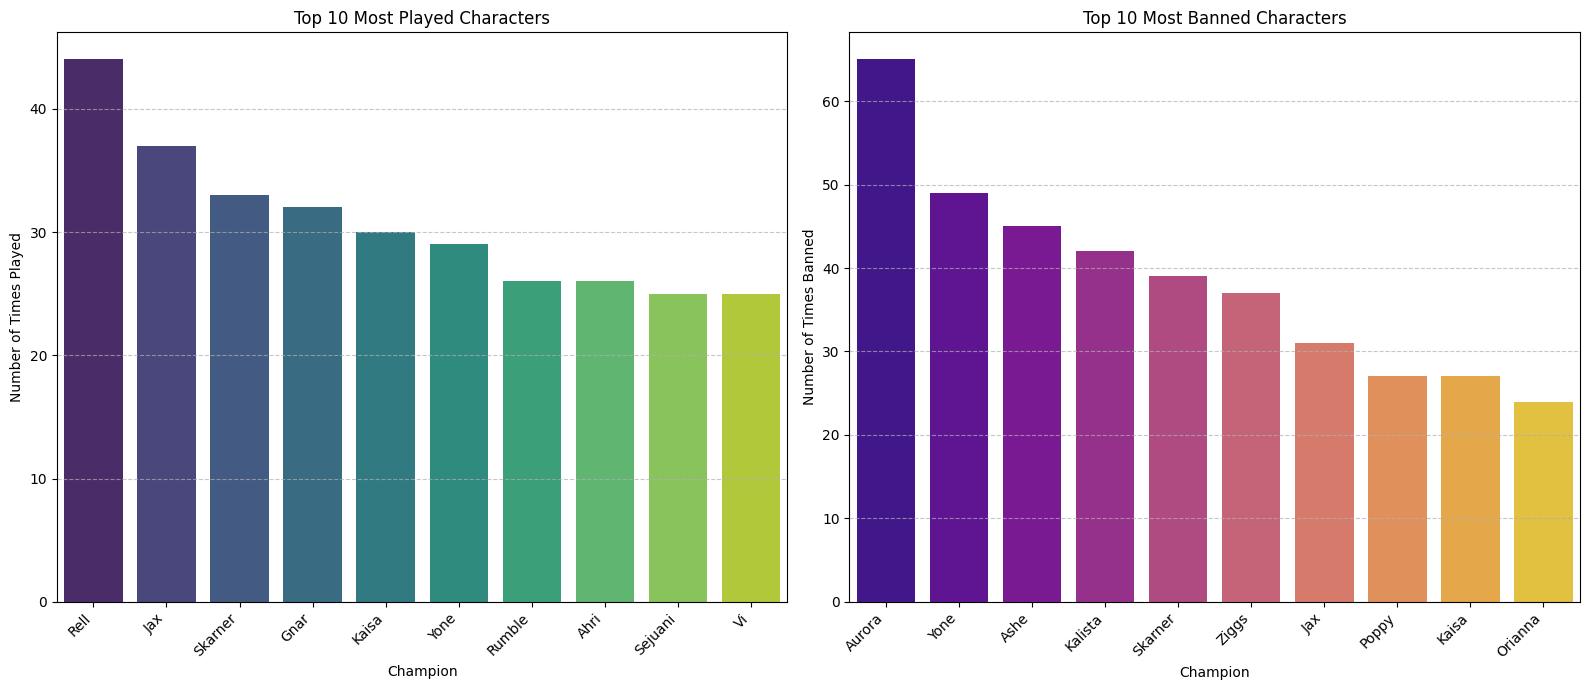


Combined analysis and visualization complete for top played and banned characters.


In [20]:
print("Analyzing top 10 most played and most banned characters...")

# --- Top 10 Most Played Characters ---
print("\n--- Top 10 Most Played Characters ---")
champion_counts = df['champion'].value_counts()
top_10_champions = champion_counts.head(10)
print(top_10_champions)

# --- Top 10 Most Banned Characters ---
print("\n--- Top 10 Most Banned Characters ---")
ban_counts = df['ban'].value_counts()
top_10_bans = ban_counts.head(10)
print(top_10_bans)

plt.figure(figsize=(16, 7)) 

# Plot 1: Top 10 Most Played Characters
plt.subplot(1, 2, 1)
sns.barplot(x=top_10_champions.index, y=top_10_champions.values, palette='viridis',
            hue=top_10_champions.index, legend=False)
plt.title('Top 10 Most Played Characters')
plt.xlabel('Champion')
plt.ylabel('Number of Times Played')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Top 10 Most Banned Characters
plt.subplot(1, 2, 2)
sns.barplot(x=top_10_bans.index, y=top_10_bans.values, palette='plasma',
            hue=top_10_bans.index, legend=False)
plt.title('Top 10 Most Banned Characters')
plt.xlabel('Champion')
plt.ylabel('Number of Times Banned')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent plots from overlapping
plt.show()

print("\nCombined analysis and visualization complete for top played and banned characters.")

Step 21: We analyze the performance of the top 3 teams

Creating a Radar Chart to compare team performance...

Comparing the following teams: ['T1', 'BLG', 'LNG']


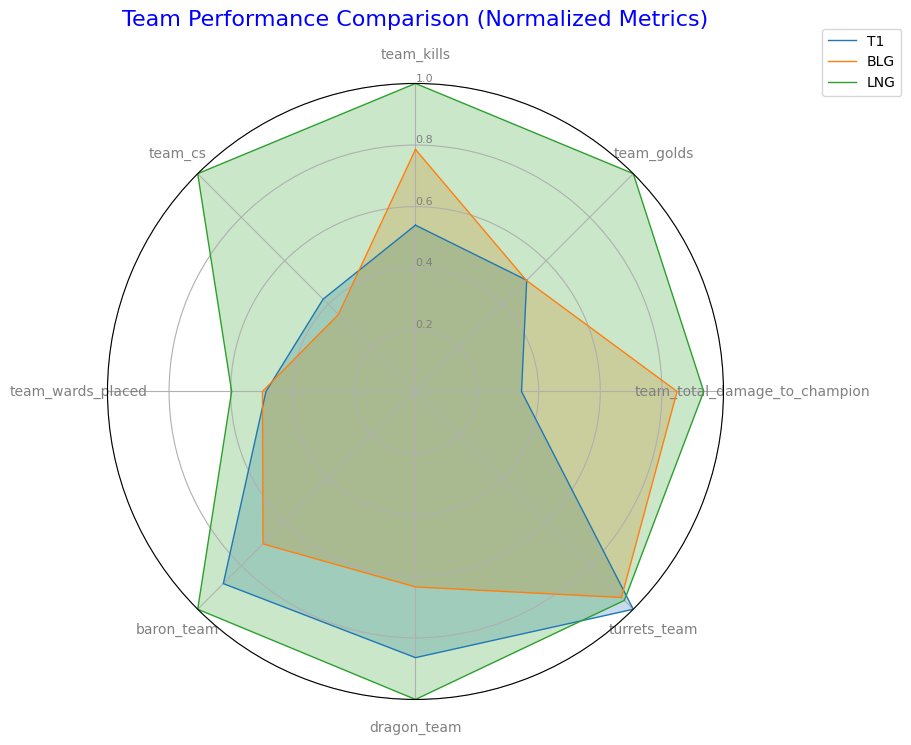


Radar Chart generation complete.


In [21]:
print("Creating a Radar Chart to compare team performance...")

if 'team_overall_performance' not in locals():
    print("Error: 'team_overall_performance' not found. Please ensure Cell 19 has been run.")
else:
    # 1. Select Teams for Comparison
    teams_to_compare = team_overall_performance.sort_values(by='Win_Rate', ascending=False).head(3).index.tolist()
    print(f"\nComparing the following teams: {teams_to_compare}")

    # 2. Select Metrics for the Radar Chart
    metrics_for_radar = [
        'team_kills', 
        'team_golds', 
        'team_total_damage_to_champion', 
        'turrets_team',
        'dragon_team',
        'baron_team',
        'team_wards_placed',
        'team_cs',
    ]

    # Filter team_overall_performance to get data for selected teams and metrics
    radar_data = team_overall_performance.loc[teams_to_compare, metrics_for_radar]

    # Handle potential missing metrics if they didn't exist in team_overall_performance
    existing_metrics = [m for m in metrics_for_radar if m in radar_data.columns]
    radar_data = radar_data[existing_metrics]

    if radar_data.empty:
        print("No data found for selected teams and metrics. Check team names or metric list.")
    else:
        # 3. Normalize Metrics (Min-Max Scaling)
        scaler = MinMaxScaler()
        all_metrics_data = team_overall_performance[existing_metrics]
        scaler.fit(all_metrics_data) # Fit on the full range of data
        normalized_radar_data = pd.DataFrame(scaler.transform(radar_data), columns=existing_metrics, index=teams_to_compare)

        # 4. Prepare Data for Plotting
        num_vars = len(existing_metrics)
        # Calculate angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles = angles + angles[:1]
        
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Plot each team's performance
        for team in teams_to_compare:
            values = normalized_radar_data.loc[team].tolist()
            values = values + values[:1]
            ax.plot(angles, values, linewidth=1, linestyle='solid', label=team)
            ax.fill(angles, values, alpha=0.25) 

        # Add labels for metrics
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1) 
        ax.set_rlabel_position(0) 
        plt.xticks(angles[:-1], existing_metrics, color='grey', size=10) 
        ax.tick_params(axis='x', pad=10) 
        
        # Set radial tick labels
        plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=8)
        plt.ylim(0, 1)

        plt.title('Team Performance Comparison (Normalized Metrics)', size=16, color='blue', y=1.08)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.show()

print("\nRadar Chart generation complete.")